<header style="text-align: center;">
    <h1 style="font-variant: small-caps; padding-bottom: .5em;">
        Diferenças Finitas
    </h1>
</header>
<!-- Endliche Differenzmethode -->

Primeiramente vale comentar um pouco sobre nossa escolha de
### Notação:

* $\texttt{n}$ é a quantidade das (idênticas) subdivisões do intervalo de tempo entre $\mathtt{t_0}$ e $\mathtt{t_n}$.


* $\mathbf{t} \, = \, [\mathtt{t_0}, \; \ldots, \; \mathtt{t_n}]^\top \, \equiv \, \mathtt{linspace}( \mathtt{t_0}, \, \mathtt{t_n}, \, n+1); \quad \mathtt{t_j} = \mathtt{t_0} + j \ h, \; h = \dfrac{\mathtt{t_n} - \mathtt{t_0}}{n}$


* $\mathbf{p} \,=\, [p_0, \; \ldots, \; p_n]^\top$ representa o ângulo $\theta$ em cada $\mathtt{t_j}$, enquanto


* $\mathbf{v} \,=\, [v_0, \; \ldots, \; v_n]^\top$ representa a velocidade angular respectiva.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
n, g, L = 300, 10., 1.
t0, tn = np.pi, np.pi**2
p0, v0 = np.pi/24, 0.

### Modelagem do Problema
Escrevendo $x(t) = \pmatrix{p(t) \\ v(t)}$, linearizamos a expressão

$$\dfrac{d}{dt} \pmatrix{p \\v} = \pmatrix{v \\ -\frac{g}{L} \sin( \, p \, )}$$

pela aproximação $\sin(p(t)) \approx p(t)$, resultando na seguinte equação linear:

$$\dfrac{d}{dt} \pmatrix{p \\ v} = \pmatrix{\;0 & 1 \\ -\frac{g}{L} & 0} \pmatrix{p \\ v},$$

o que resumidamente pode ser escrito como $\dot x = M x$, com o benefício de, por um segundo de distração, esquecermos que $M$ é uma matriz e arriscarmos a solução analítica:
$x(t) = \exp(M \, t) \cdot x_0$, cuja validade verificaremos mais adiante.

### Proposta de Solução 1

In [6]:
M = np.array([[0., 1.], [-g/L, 0.]])
n=400
t = np.linspace(t0, tn, n+1)
h = (tn - t0) / n
p, v = np.zeros((2, n+1))
p[0], v[0] = p0, v0

'''
def nice_old_matrix(n, h, g, l):
    p = lambda i: 2*i
    v = lambda i: 2*i + 1

    mat = np.zeros((2*(n+1), 2*(n+1)), dtype=float)
    mat[p(0), p(0)] = 1.0
    mat[v(0), v(0)] = 1.0

    for i in range(1, n+1):
        mat[p(i), p(i-1)] = -1
        mat[p(i), p(i)] = 1
        mat[p(i), v(i)] = -h

        mat[v(i), v(i-1)] = -1
        mat[v(i), v(i)] = 1
        mat[v(i), p(i)] = h * g / l;
    return mat


def new_rows(diff, x_index, n, h):
    """
    diff é a função que associa a cada xk = [pk, vk] o vetor dx/dt em t=tk.
    Retorna vetores a acrescentar na matriz de igualdades (começando na linha (2 * x_index)),
    representando vetores tais como diff_matrix * x[k]  -  (x[k+1] - x[k-1]) / (2 h)  =  0.
    *no caso, retornaria [[0,0], ..., [0,0], x[k-1], (2 h) * M x[k], -1 * x[k+1], [0,0], ..., [0,0]].T
    """
    raise NotImplementedError()  # estava pensando em generalizar para aproximações de ordem superior... :')
'''

def matrix(n, h, g, l):
    M = np.zeros((2*n+2, 2*n+2), dtype=float)
    ii = np.arange(2, 2*n, 2)  #=> [2, 4, 6, ..., 2*n-2]
    """
    Legenda para os índices ii:
    ii-2 => p[k-1]
    ii-1 => v[k-1]
    ii   => p[ k ]
    ii+1 => v[ k ]
    ii+2 => p[k+1]
    ii+3 => v[k+1]
    """
    M[[0,1], [0,1]] = 1

    # Primeiro conjunto de igualdades:  v[k] = (p[k+1] - p[k-1]) / (2 h)
    M[ii, ii-2] =  1
    M[ii, ii+1] = 2*h   # (+1) * p[k-1] + (2 h) * v[k] + (-1) * p[k+1] = 0
    M[ii, ii+2] = -1

    # Segundo conjunto de igualdades:  (-g/l) * p[k] = (v[k+1] - v[k-1]) / (2 h)
    M[ii+1,ii-1] =  1
    M[ii+1,ii+3] = -1   # (+1) * v[k-1] + (-2hg/l) * p[k] + (-1) * v[k+1] = 0
    M[ii+1, ii ] = -2*h*g / l

    '''
    # Ajeitando a igualdade do último ponto com uma aproximação O(h^2):
    #   f'(x[-1]) = 3/2 x[-1] - 2 x[-2] + 0.5 x[-3]

    # ÍNDICES:
    # [[-6]] [[-5]] [[-4]] [[-3]] [[-2]] [[-1]]
    # p[-3]  v[-3]  p[-2]  v[-2]  p[-1]  v[-1]

    # h * M * x[-1] = 0.5 x[-3] - 2 x[-2] + 3/2 x[-1]
    # [hv[-1] ; (-h*g/l)*p[-1]]  =  0.5 x[-3] - 2 x[-2] + 3/2 x[-1]

    # 0.5 * [[p[-3]]] + (-2) * [[p[-2]]] +  (3/2)  * [[p[-1]]] + (-h)  * [[v[-1]]] = 0
    # 0.5 * [[v[-3]]] + (-2) * [[v[-2]]] + (h*g/l) * [[p[-1]]] + (3/2) * [[v[-1]]] = 0

    # (+1) * [[p[-3]]] + (-4) * [[p[-2]]] +   ( 3 )   * [[p[-1]]] + (-2*h) * [[v[-1]]] = 0
    # (+1) * [[v[-3]]] + (-4) * [[v[-2]]] + (2*h*g/l) * [[p[-1]]] + ( 3 )  * [[v[-1]]] = 0

    # (+1) * [[-6]]  + (-4) * [[-4]]  +   ( 3 )   * [[-2]]  + (-2*h) * [[-1]] = 0
    # (+1) * [[-5]]  + (-4) * [[-3]]  + (2*h*g/l) * [[-2]]  + ( 3 )  * [[-1]] = 0
    '''

    M[[-2]*6, [-6, -5, -4, -3, -2, -1]] = [1,  0., -4,  0,  3, -2*h]
    M[[-1]*6, [-6, -5, -4, -3, -2, -1]] = [0., 1, 0, -4, 2*h*g/l, 3]

    return M  # Como já estou começando com M = np.eye(...), não precisei fazer M[ii,ii] = 1

MATRIX():
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.66 ms

SOLVE():
CPU times: user 116 ms, sys: 112 ms, total: 228 ms
Wall time: 68.5 ms


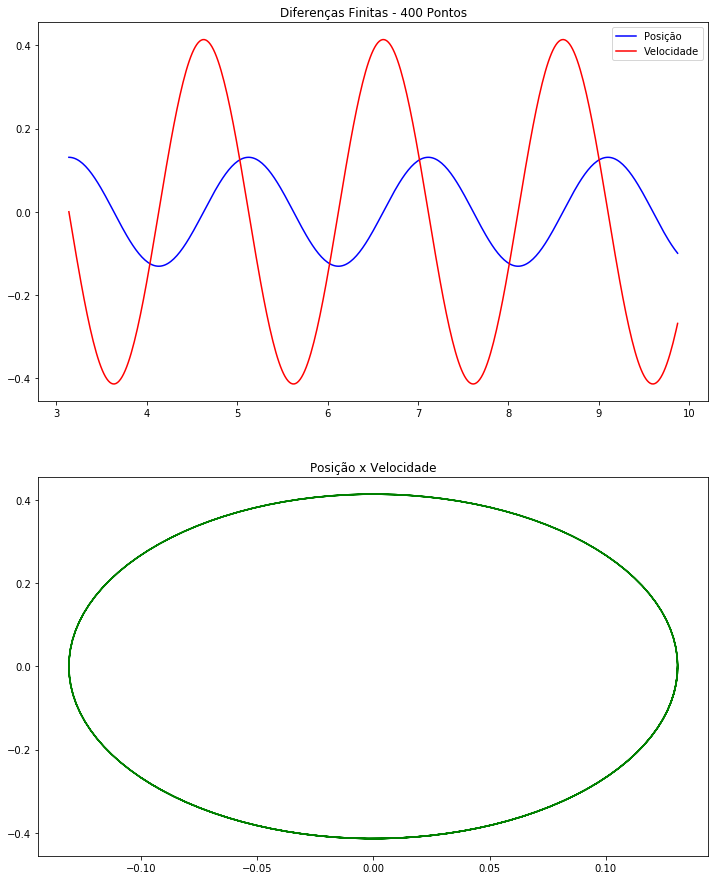

In [3]:
print("MATRIX():")
%time A = matrix(n, h, g, L)
wat = lambda A: sum(print("[",*[("{:.>6.2f}".format(k) if k else ".....o") for k in row],"]",sep="..") or 0 for row in A) or None
# wat(A)

b = np.zeros_like(A[0])
b[[0,1]] = [p0, v0]

print("\nSOLVE():")
%time sol = np.linalg.solve(A, b)
p_sol, v_sol = sol[::2], sol[1::2]

plt.figure(figsize=(12, 7.416*2 + .5))
plt.subplot(2,1,1)
plt.title("Diferenças Finitas - {} Pontos".format(n))
plt.plot(t, p_sol, 'b', label='Posição')
plt.plot(t, v_sol, 'r', label='Velocidade')
plt.legend(loc=0)
plt.subplot(2,1,2)
plt.title("Posição x Velocidade")
plt.plot(p_sol, v_sol, 'g')
plt.show()

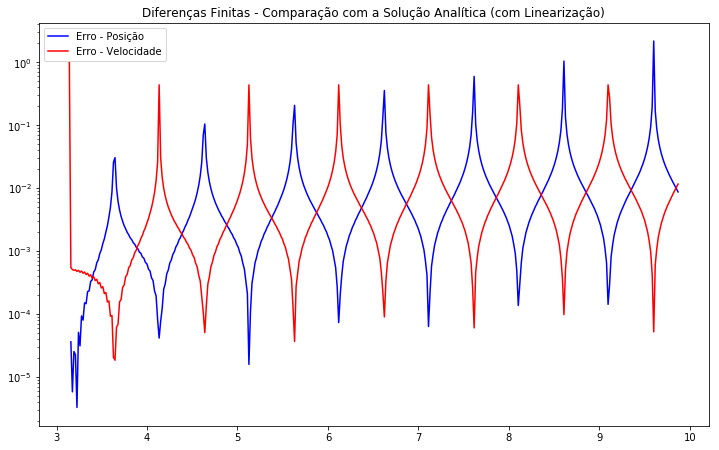

In [5]:
# from scipy.linalg import expm  # tt = 2 ; EM = expm(M * tt)
x0 = np.array([p0, v0])
w, P = np.linalg.eig(M)
invp_x0 = np.linalg.solve(P, x0)

c = np.diag(np.exp(-t0 * w)) @ invp_x0
xt = lambda t: np.real(P @ np.diag(np.exp(t*w)) @ c)

pa, va = np.array([xt(k) for k in t]).T
plt.figure(figsize=(12, 7.416))
plt.title("Diferenças Finitas - Comparação com a Solução Analítica (com Linearização)")
plt.semilogy(t, abs((pa-p_sol)/pa), 'b', label='Erro - Posição')
plt.semilogy(t, abs((va-v_sol)/va), 'r', label='Erro - Velocidade')
plt.legend(loc=0)
plt.show()